# Moskalev Artem. Assignment 6

### Task 1

<center>Consider an ordinary LP in inequality form:<br><br>
$$\min c^Tx$$
$$\textrm{subject to}$$
$$Ax \leq b$$<br>
Consider an indicator function $I$:<br>
$I(u) = \begin{cases} 0, & \mbox{if } u \leq 0 \\ \infty, & \mbox{if } u > 0 \end{cases}$<br><br><br>
Let's use it and reformulate our fuction:<br>
$$\min c^Tx + \sum_{i=1}^n I(a_i^Tx-b)$$<br>
And derive an approximation through a logarithmic barrier as daddy Boyd tought:
$$\min c^Tx- \sum_{i=1}^n \frac 1 t \log (b_i - a_i^Tx) \Leftrightarrow \min tc^Tx- \sum_{i=1}^n \log (b_i - a_i^Tx)$$
Apparently the objective is also convex because of $\frac 1 t$ and $\log(.)$ are differentiable<br><br><br>
Consider $\phi (x) = - \sum_{i=1}^n \log (b_i - a_i^Tx)$, so our optimization problem is turned into:
$$\min tc^Tx + \phi (x)$$<br><br>
The gradient of our barrier function will look like:
$$\nabla \phi (x) = \sum_{i=1}^n \frac 1 {b_i-a^T_ix}a_i = (d_i = \frac 1 {b_i - a_i^Tx}) = A^Td$$
$$\nabla^2 \phi (x) = \sum_{i=1}^n \frac 1 {(b_i-a^T_ix)^2}a_ia_i^T = A^T diag^2 (d)$$<br><br>
Now we can solve a problem using a Newton method appleid to $\nabla (\min tc^Tx + \phi (x))$:<br>
$$x_{k+1} := x_k - (\nabla^2 \phi(x) A)^{-1}(\nabla (\min tc^Tx + \phi (x)))$$
what we can rewright as:<br><br>
$$x_{k+1} := x_k - (A^T diag^2(d)A)^{-1}(tc^T+A^Td)$$ 

In [1]:
import numpy as np

def Newton_baby(init_x, A, B, C, t, n_iter,eps=1e-10):
    x_k = init_x.copy()
    #d = np.power(B - A@x_k,-1)
    alp = 1/t
    hist = [init_x]
    
    for _ in range(n_iter):
        d = 1/(B-A@x_k)
        Jacobian=np.dot(A.T,d) + t*C
        Hessian= np.dot(A.T, np.dot(np.diag(np.power(d,2)),A))
        
        if np.linalg.norm(np.linalg.det(Hessian)) <= eps: 
            #print('Terminated Hessian')
            break
        x_k = x_k - alp*np.dot(np.linalg.inv(Hessian),Jacobian)
        
        if np.linalg.norm(hist[-1]-x_k) <= eps:
            #print('Terminated x_k')
            break
        hist.append(x_k)
    return x_k#, hist

In [2]:
def iteration(init_x, A, B, C, n_iter):
    """Solve a LP in inequality form using an iterative solver based on Newton metod.

    Args:
        init_x: Initial solution that function begins to iterate with.
        A: The matrix of coeficients in inequality constraints (left-hand side)
        B: The right-hand side of inequality constraints
        C: Coeficients of desision variables in objective function
        n_iter: number of iterations

    Returns:
        Return a history how our optimal solution changes with each iteration.
    """
    x_k = init_x.copy()
    hist= [x_k]
    for t in range(2,n_iter):
        x_k  = Newton_baby(init_x=x_k, A=A, B=B, C=C, t=t, n_iter=10000)
        hist.append(x_k)
        #t *= mu
    return hist

###### Exapmle 1:

In [3]:
c = np.array([-1,-1])
A=np.array([[3,1],[1,4]])
b = np.array([2,1])
x0 = np.array([0,0])

In [4]:
history = iteration(init_x=x0, A=A, B=b, C=c, n_iter=100)

In [5]:
history[-1]

array([ 0.62794612,  0.07912457])

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize():
    x_,y_ = list(), list()
    for each_solution in history:
        x_.append(each_solution[0])
        y_.append(each_solution[1])
    grid=[np.array([x,y]) for x in np.arange(-1,1,0.01) for y in np.arange(-1,1,0.01)]
    feasible_x,feasible_y = list(), list()
    for each_pair in grid:
        if all(A@each_pair <= b):
            feasible_x.append(each_pair[0])
            feasible_y.append(each_pair[1])
    plt.figure(figsize=(7,5))
    plt.plot(feasible_x,feasible_y, alpha=.4)
    plt.scatter(x_,y_,color='r')
    plt.scatter(x_[-1],y_[-1],s=100,color='g')
    plt.plot(x_,y_,'--')
    plt.grid()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title('Feasible set and Central Path')
    plt.show()

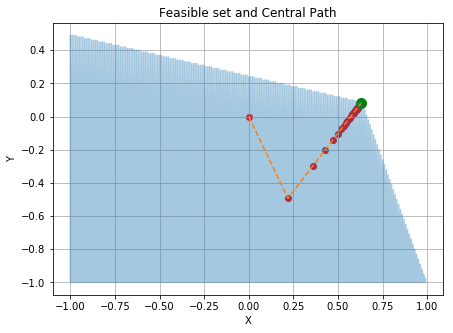

In [7]:
visualize()

###### Example 2:

In [8]:
c = np.array([-1,-1])
A=np.array([[2,1],[1,2]])
b = np.array([1,1])
x0 = np.array([0,0])
history = iteration(init_x=x0, A=A, B=b, C=c, n_iter=100)
history[-1]

array([ 0.32323232,  0.32323232])

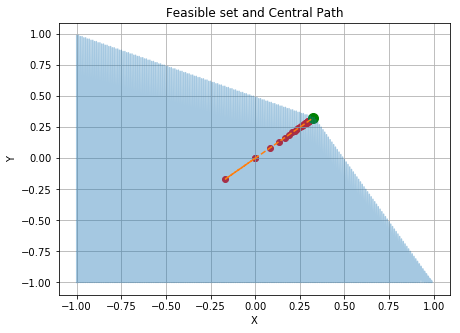

In [9]:
visualize()

###### Example 3:

In [10]:
c = np.array([1,1])
A=np.array([[-3,1],[1/3,-1]])
b = np.array([1,2/3])
x0 = np.array([0,0])
history = iteration(init_x=x0, A=A, B=b, C=c, n_iter=100)
history[-1]

array([-0.61489898, -0.86489898])

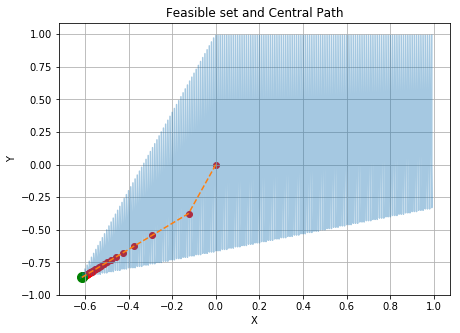

In [11]:
visualize()

### Task 2

<center>Consider our initial LP that can be formulaten in the following way:<br><br>
$\min_x 10 \sum_j x_j - \sum_{i,j} p_{ij}x_jx_i$, s.t. <br>
$x \in \{0;1\}$, where $p_{ij}$ is a matrix of profits while connecting $i$ and $j$ cities<br><br>
Let's rewright our problem as:<br>
$\min_x 10 \sum_j x_j - \sum_{ij} p_{ij}x_j + \sum_{ij} p_{ij} \max(0,x_j-x_i)$, s.t. <br>
$x \in \{0;1\}$<br>
Thus, the last element will kill the second one when $x_i \geq x_j$<br><br>
If we regroup we get an equivalent formulation:<br>
$\min_x \sum_j (10 - \sum_i p_{ij})x_j + \sum_{ij} p_{ij} \max(0,x_j-x_i)$, s.t.<br>
$x \in \{0,1\}$<br><br>
We need to specify the source and sink: $x_{source} = 0, x_{sink}=1$. We also need to extend our profit matrix, what can be done as follows:<br>
$p_{source,j}=\max (0,10-\sum p_{ij})$<br>
$p_{j, sink}=\max (0,\sum p_{ij}-10)$<br><br>
Thus, we converged our problem to st-mincut:<br>
$\min_x \sum p_{ij} \max(0,x_j-x_i)$, s.t.<br>
$x \in \{0;1\}$<br>
$x_{source}=0$<br>
$x_{sink}=1$<br><br>
If we substitute $\max(0,x_j-x_i)$ wit $a_{ij}$ we are coming to the following simlpe form:<br>
$\min_x \sum p_{ij}a_{ij}$, s.t.<br><br>
$a_{ij} \geq 0$<br>
$a_{ij} \leq 1$<br>
$a_{ij} \geq \max(0,x_j-x_i)$<br>
$x \in \{0;1\}$<br>
$x_{sorce}=0$<br>
$x_{sink}=1$<br><br>
Further, we just proceed with the relaxation setting $0 \leq x \leq 1$

Let's try to code all this staff:

In [12]:
import numpy as np
import scipy.sparse

def Mat(road_list):
    data_list = [[city_dict[city_i], city_dict[city_j], length ] for city_i, city_j, length in road_list]
    data_array = np.asarray(data_list)
    mat = scipy.sparse.csr_matrix((data_array[:, 2], (data_array[:, 0], data_array[:, 1])), shape=(m,m), dtype=float)
    return mat

cities = ['Atlanta','Boston', 'Calgary', 'Charleston','Chicago', 'Dallas', 'Denver', 'Duluth', 'ElPaso', 
          'Helena', 'Houston', 'KansasCity', 'LasVegas', 'LittleRock', 'LosAngeles', 'Miami', 'Montreal', 
          'Nashville', 'NewOrleans', 'NewYork', 'OklahomaCity', 'Omaha', 'Phoenix', 'Pittsburgh', 
          'Portland', 'Raleigh', 'SaintLouis','SaltLakeCity', 'SanFrancisco','SantaFe', 'SaultStMarie', 
          'Seattle', 'Toronto', 'Vancouver', 'Washington', 'Winnipeg']

city_dict = {city: i for i, city in enumerate(cities)}
m = len(cities)

blue = [('Winnipeg','Helena',4), 
        ('Portland','SaltLakeCity',6), 
        ('Omaha','Chicago',4), 
        ('Montreal','NewYork',3), 
        ('KansasCity','SaintLouis',2), 
        ('SantaFe','OklahomaCity',3), 
        ('Atlanta','Miami',5)]

white = [('Calgary','Winnipeg',6), 
         ('Chicago','Toronto',4), 
         ('SaintLouis','Chicago',2), 
         ('Pittsburgh','NewYork',2),
         ('SanFrancisco','SaltLakeCity',5), 
         ('Phoenix','Denver',5), 
         ('LittleRock','Nashville',3)]

green = [('Portland','SanFrancisco',5), 
         ('Helena','Denver',4), 
         ('SaintLouis','Pittsburgh',5), 
         ('LittleRock','NewOrleans',3), 
         ('ElPaso','Houston',6)]

red = [('Helena','Omaha',5), 
       ('Denver','OklahomaCity',4), 
       ('ElPaso','Dallas',4), 
       ('NewOrleans','Miami',6),
       ('NewYork','Boston',2), 
       ('Duluth','Chicago',3)]

purple = [('Helena','SaltLakeCity',3), 
          ('Denver','Omaha',4), 
          ('Duluth','Toronto',6), 
          ('Charleston','Miami',4),
          ('SanFrancisco','LosAngeles',3)]

orange = [('LasVegas','SaltLakeCity',3), 
          ('Helena','Duluth',6), 
          ('Chicago','Pittsburgh',3), 
          ('Denver','KansasCity',4),
          ('NewYork','Washington',2), 
          ('Atlanta','NewOrleans',4)]

black = [('LosAngeles','ElPaso',6), 
         ('Winnipeg','Duluth',4), 
         ('SaultStMarie','Montreal',5), 
         ('Nashville','Raleigh',3)]

yellow = [('Seattle','Helena',6), 
          ('ElPaso','OklahomaCity',5), 
          ('Nashville','Pittsburgh',4)]

gray = [('Vancouver','Seattle',1), 
    ('Portland','Seattle',1),
    ('Vancouver','Calgary',3),
    ('Seattle','Calgary',4),
    ('Calgary','Helena',4),
    ('Winnipeg','SaultStMarie',6),
    ('Duluth','SaultStMarie',3),
    ('SaultStMarie','Toronto',2),
    ('Toronto','Montreal',3),
    ('Montreal','Boston',2),
    ('Toronto','Pittsburgh',2),
    ('LasVegas','LosAngeles',2),
    ('LosAngeles','Phoenix',3),
    ('Phoenix','ElPaso',3),
    ('ElPaso','SantaFe',2),
    ('Phoenix','SantaFe',3),
    ('SantaFe','Denver',2),
    ('Duluth','Omaha',2),
    ('Omaha','KansasCity',1),
    ('KansasCity','OklahomaCity',2),
    ('OklahomaCity','Dallas',2),
    ('Dallas','Houston',1),
    ('Houston','NewOrleans',2),
    ('Dallas','LittleRock',2),
    ('OklahomaCity','LittleRock',2),
    ('LittleRock','SaintLouis',2),
    ('SaintLouis','Nashville',2),
    ('Nashville','Atlanta',1),
    ('Atlanta','Charleston',2),
    ('Charleston','Raleigh',2),
    ('Atlanta','Raleigh',2),
    ('Raleigh','Washington',2),
    ('Raleigh','Pittsburgh',2),
    ('Washington','Pittsburgh',2)]

profit = Mat(blue)*1.+Mat(white)*1.5+Mat(green)*2.0+Mat(red)*2.0+Mat(purple)*2.5\
        +Mat(orange)*1.0+Mat(black)*1.0+Mat(yellow)*2.0+Mat(gray)*1.0
profit

<36x36 sparse matrix of type '<class 'numpy.float64'>'
	with 77 stored elements in Compressed Sparse Row format>

In [13]:
profit_=0.5*(profit + profit.T).copy() #we want to have symmetric matrix for profits
#profit_=profit_.todense()
costs=10

In [14]:
import cvxpy as cvx

x = cvx.Variable(2+len(cities))
a_ij = cvx.Variable(2+len(cities), 2+len(cities))
x_ope = np.ones(shape=(2+len(cities),1))@x.T - x@np.ones(shape=(1,2+len(cities)))

Prof_M = np.zeros((2+len(cities), 2+len(cities)))
Prof_M[1:Prof_M.shape[0]-1,Prof_M.shape[0]-1] = np.maximum(0, np.sum(profit_, axis=1)-costs).ravel()
Prof_M[0,1:Prof_M.shape[0]-1] = np.maximum(0, costs - np.sum(profit_, axis=1)).ravel()
Prof_M[1:Prof_M.shape[0]-1,1:Prof_M.shape[0]-1] = np.asarray(profit_.todense())

constraints = list()
constraints.append(x_ope<=a_ij)
constraints.append(x <= 1)
constraints.append(x >=0)
constraints.append(x[0] == 0)
constraints.append(x[-1] == 1)
constraints.append(a_ij >= 0)

In [15]:
obj = cvx.Minimize(cvx.sum_entries(cvx.mul_elemwise(Prof_M,a_ij)))
#obj = cvx.Minimize(cvx.trace(a_ij*Prof_M.T)) try ##same

problem = cvx.Problem(obj, constraints)
problem.solve()
print ('prob status =', problem.status)
print ('prob value =', problem.value)
print()

cities_idx=np.asarray(x.value[1:x.value.shape[0]-1]).ravel()
cities_idx = list(map(lambda x: np.int(x),np.round(cities_idx)))
print('Cities to operate:', sum(cities_idx),'\n')
operate_cities=[cities[i] for i,p in enumerate(cities_idx) if bool(p)]
print(operate_cities)

prob status = optimal
prob value = 47.00000000097963

Cities to operate: 27 

['Atlanta', 'Calgary', 'Charleston', 'Chicago', 'Dallas', 'Denver', 'Duluth', 'ElPaso', 'Helena', 'Houston', 'LittleRock', 'LosAngeles', 'Miami', 'Nashville', 'NewOrleans', 'OklahomaCity', 'Omaha', 'Phoenix', 'Pittsburgh', 'Portland', 'SaintLouis', 'SaltLakeCity', 'SanFrancisco', 'SaultStMarie', 'Seattle', 'Toronto', 'Winnipeg']


###### A colored image is in the link below:

https://drive.google.com/open?id=1BOFVAq7ePdPijiGu8IfHuH4Afm8UFlq4